In [1]:
from itertools import chain
from functools import partial
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from ocddetection.data import SENSORS
from ocddetection.models import bidirectional

In [2]:
def read_meta(path):
    df = pd.read_csv(path)
    df['ms'] = pd.TimedeltaIndex(df['0'])
    
    return df.drop(columns='0')

In [3]:
def read_augmented(path):
    return pd.read_csv(path,header=None)

In [4]:
def preprocess(ds: tf.data.Dataset, window_size: int, batch_size: int) -> tf.data.Dataset:
    def split(t: tf.Tensor):
        return t[:-1], t[-1]
    
    def flatten(X: tf.data.Dataset, y: tf.data.Dataset):
        X = X.batch(window_size, drop_remainder=True)
        y = y.batch(window_size, drop_remainder=True)

        return tf.data.Dataset.zip((X, y))
    
    def label(X: tf.Tensor, y: tf.Tensor):
        return X, tf.expand_dims(tf.round(tf.math.reduce_mean(y)), axis=-1)

    return ds \
        .map(split) \
        .window(window_size, shift=window_size // 2) \
        .flat_map(flatten) \
        .map(label) \
        .batch(batch_size) \
        .prefetch(tf.data.AUTOTUNE)

In [5]:
meta = read_meta('./data/S1-ADL4-META.csv')

In [6]:
adl = read_augmented('./data/S1-ADL4-AUGMENTED.csv')

In [7]:
ds = tf.data.Dataset.from_tensor_slices(adl.to_numpy())

In [8]:
windowed = preprocess(ds, window_size=150, batch_size=128)

In [9]:
model = bidirectional(150, len(SENSORS), 64, .6)

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [11]:
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, './checkpoints/centralized', max_to_keep=5)

In [12]:
ckpt_manager.restore_or_initialize()

'./checkpoints/centralized/ckpt-10'

In [13]:
logits = model.predict(windowed)

In [14]:
y_pred = tf.reshape(tf.math.round(tf.nn.sigmoid(logits)), (-1,)).numpy()

In [15]:
y_true = np.asarray(list(chain.from_iterable(windowed.map(lambda X, y: y).as_numpy_iterator()))).reshape((-1,))

In [22]:
idx = np.where(y_pred != y_true)

In [26]:
idx

(array([ 34,  45, 103, 104, 156, 165, 166, 171, 238, 242, 266, 271, 291,
        296, 307, 308, 309, 310, 311, 312, 313, 314, 315, 393, 397, 404,
        409, 428, 429, 435]),)

In [27]:
y_pred[307:316]

array([1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [28]:
y_true[307:316]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [29]:
(307 * 75, 316 * 75)

(23025, 23700)

In [32]:
meta.loc[307 * 75 : 316 * 75]['activity']

23025    Null
23026    Null
23027    Null
23028    Null
23029    Null
         ... 
23696    Null
23697    Null
23698    Null
23699    Null
23700    Null
Name: activity, Length: 676, dtype: object

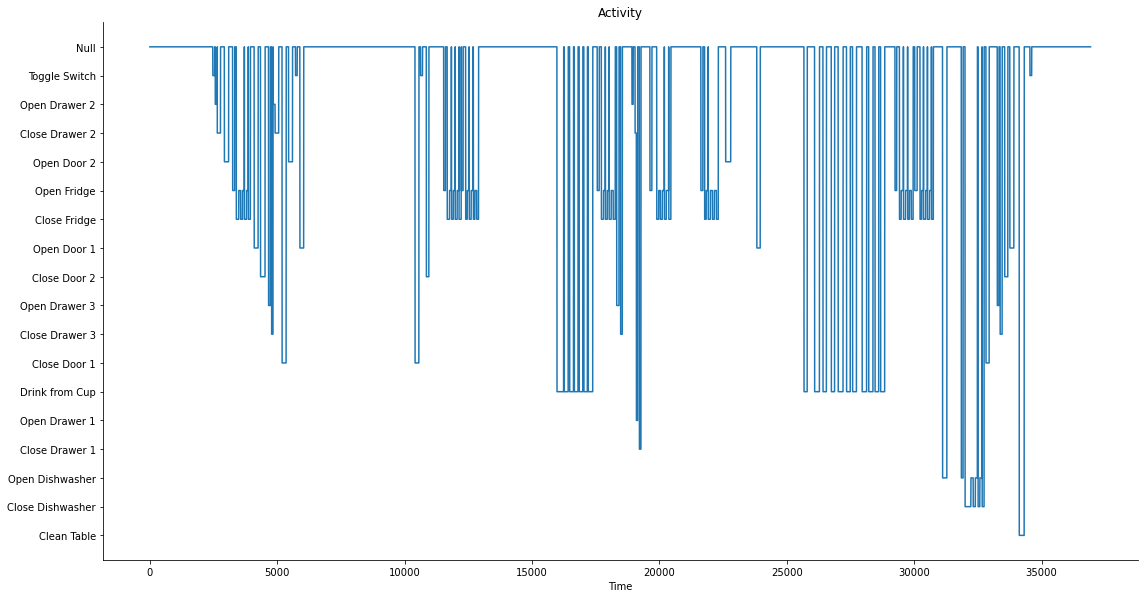

In [33]:
grid = sns.relplot(data=meta['activity'], kind='line', height=8, aspect=2)

grid.set(
    title='Activity',
    xlabel='Time',
    ylabel=''
)

plt.show()